# Imports bb

In [1]:
import matplotlib.pylab as pl
from pyvis.network import Network
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import json

# Formatting Data

In [2]:
card_graph = {}
with open ('./data/top_10k_player_decks.json') as file: # 18,051 decks in dataset
    card_graph = json.load(file)

card_occurances = {k: v for k,v in card_graph.items()}

edges = pd.DataFrame(
    {
        "source": [e for k,v in card_occurances.items() for e,w in v['edges'].items()],
        "target": [k for k,v in card_occurances.items() for e,w in v['edges'].items()],
        "weight": [w for k,v in card_occurances.items() for e,w in v['edges'].items()],
        # "color": ["red", "blue", "blue"],
    }
)

G = nx.from_pandas_edgelist(edges,
source='source',
target='target',
edge_attr='weight')

G

In [3]:
adj = pd.read_csv('./data/top_10k_player_decks_adj_matrix.csv')
adj.index = adj['Unnamed: 0'].values
adj = adj.drop(['Unnamed: 0'], axis=1)
adj = adj.replace(0, np.NaN)

In [4]:
# Converting from adjacency matrix to edge list (still goes archer -> archer queen and archer queen -> archer) this is fine because we need to do it by frequency anyways
el = adj
el.values[[np.arange(len(el))]*2]# = np.NaN
el = el.stack().reset_index()
el = el.rename({'level_0': "source", 'level_1': "target", 0: 'weight'}, axis=1) # is currently a double sided raw frequency count



/var/folders/9h/6fhghpsx3tv0tjcyk0lknrs40000gn/T/ipykernel_87447/1895298105.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  el.values[[np.arange(len(el))]*2]# = np.NaN


# Plotting

## Looking at Card Frequencies (node degree)

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


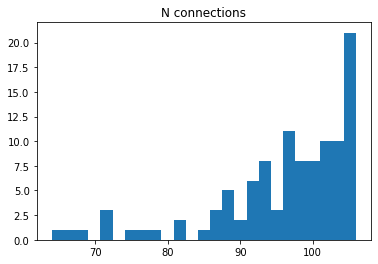

In [5]:
degs = nx.laplacian_matrix(G, weight=None).diagonal()
plt.title('N connections')
plt.hist(degs, bins=25)
plt.show()

# adj.sum(axis=1).sort_values().plot.barh(figsize=(20,20), ) # plots edge weights

## Graph Visualizations

In [10]:
nx.write_gexf(G, "test.gexf")

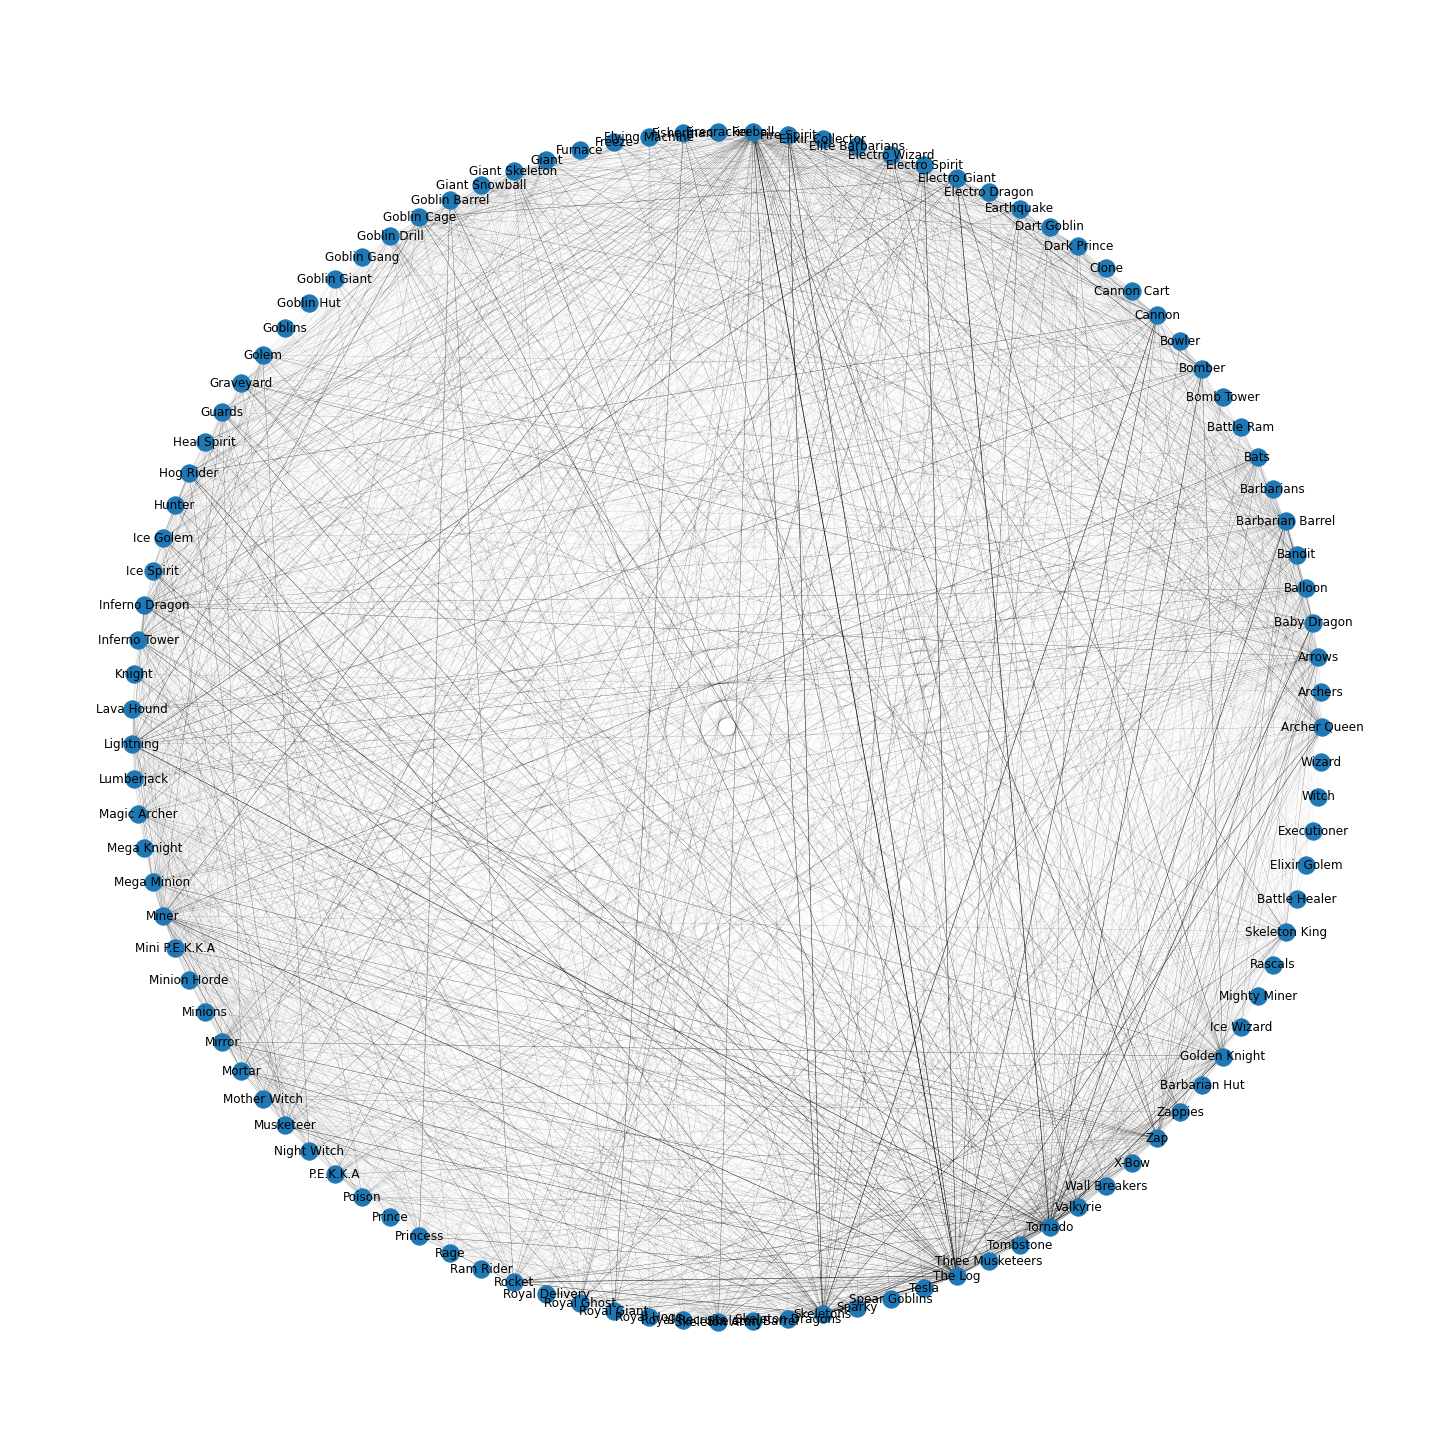

In [6]:
pl.figure(figsize=(20,20))

G = nx.from_pandas_edgelist(el, edge_attr='weight')
wts = np.array([i['weight'] for i in dict(G.edges).values()])
nx.draw_circular(G, width=wts/max(wts), with_labels=True)

/var/folders/9h/6fhghpsx3tv0tjcyk0lknrs40000gn/T/ipykernel_87447/86273950.py:5: RuntimeWarning: divide by zero encountered in log
  nx.draw_spring(G, width=(wts/max(wts)), with_labels=True, node_size=[np.log(v) * 100 for v in d])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


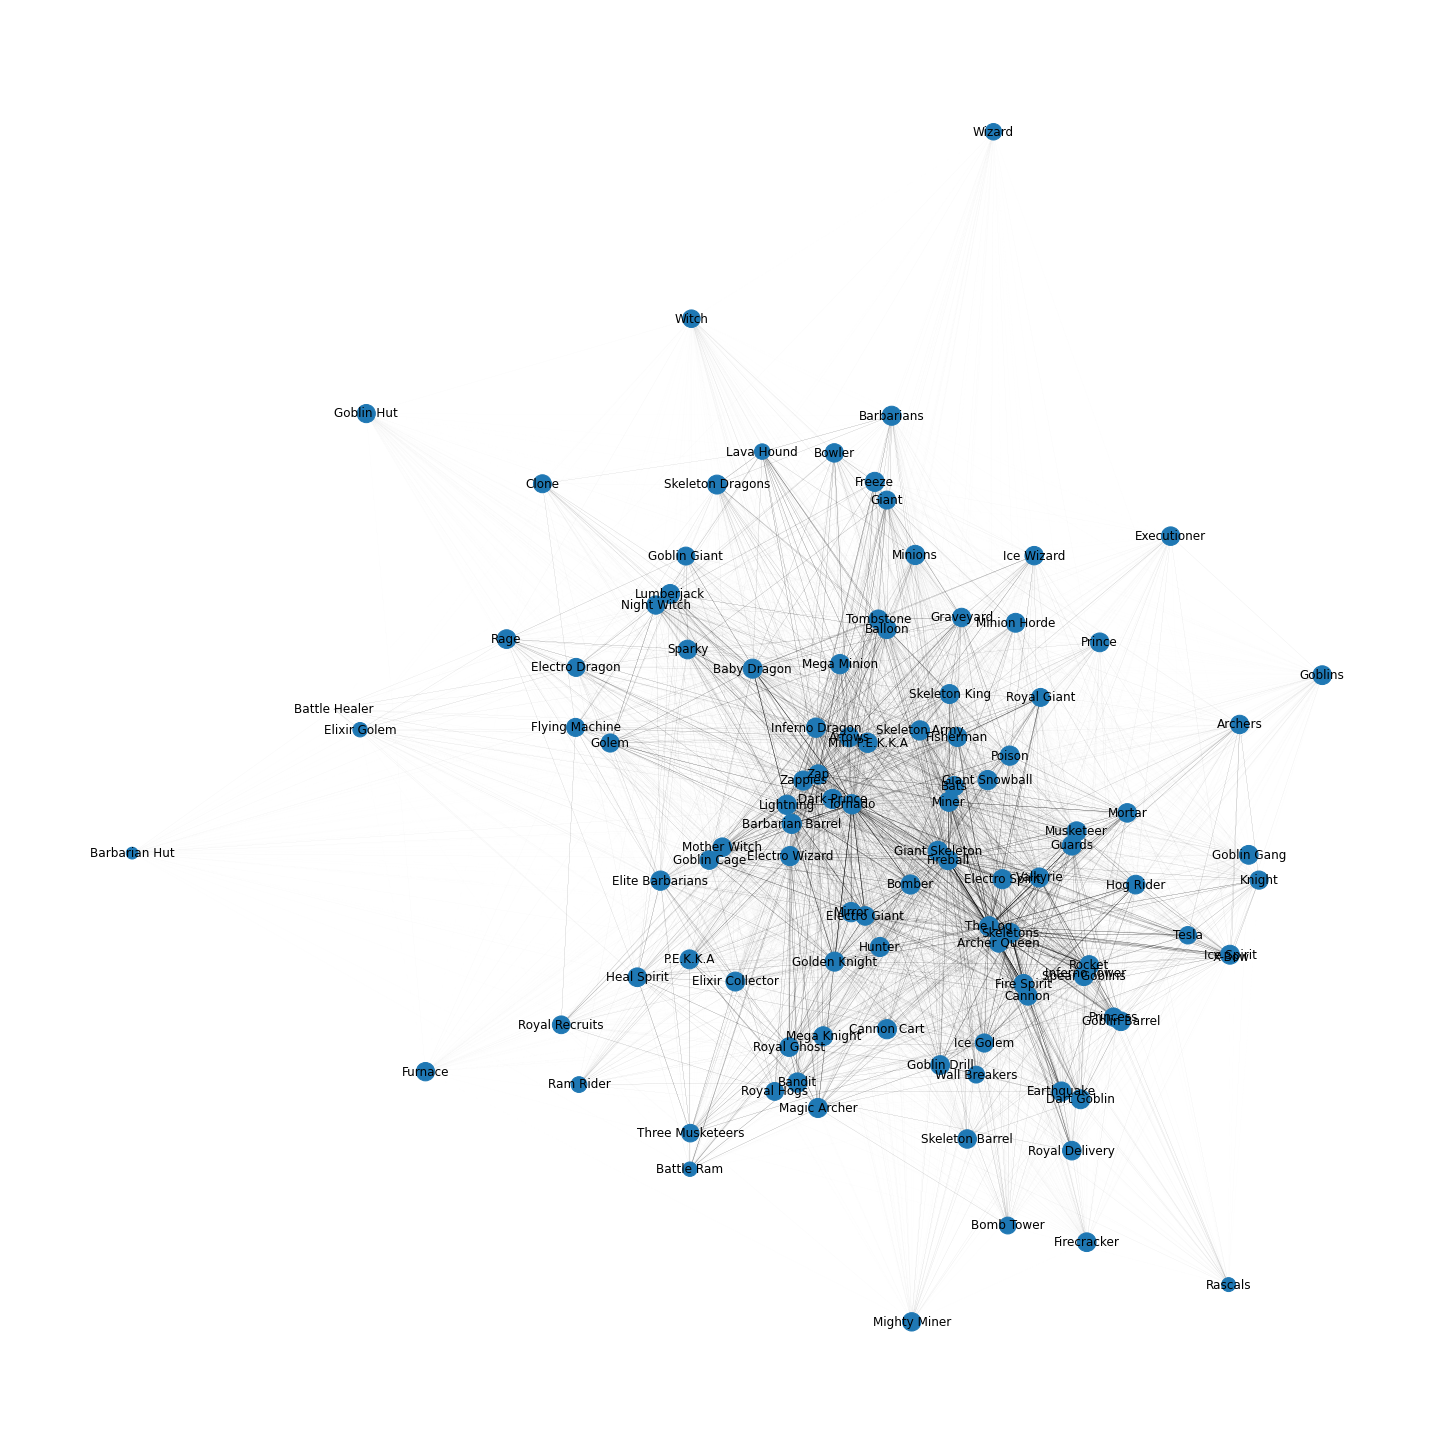

In [40]:
pl.figure(figsize=(20,20))
d = dict(G.degree, weight='weight')
d.pop('weight')
d = np.asarray(list(d.values())) - min(d.values())
nx.draw_spring(G, width=(wts/max(wts)), with_labels=True, node_size=[np.log(v) * 100 for v in d])

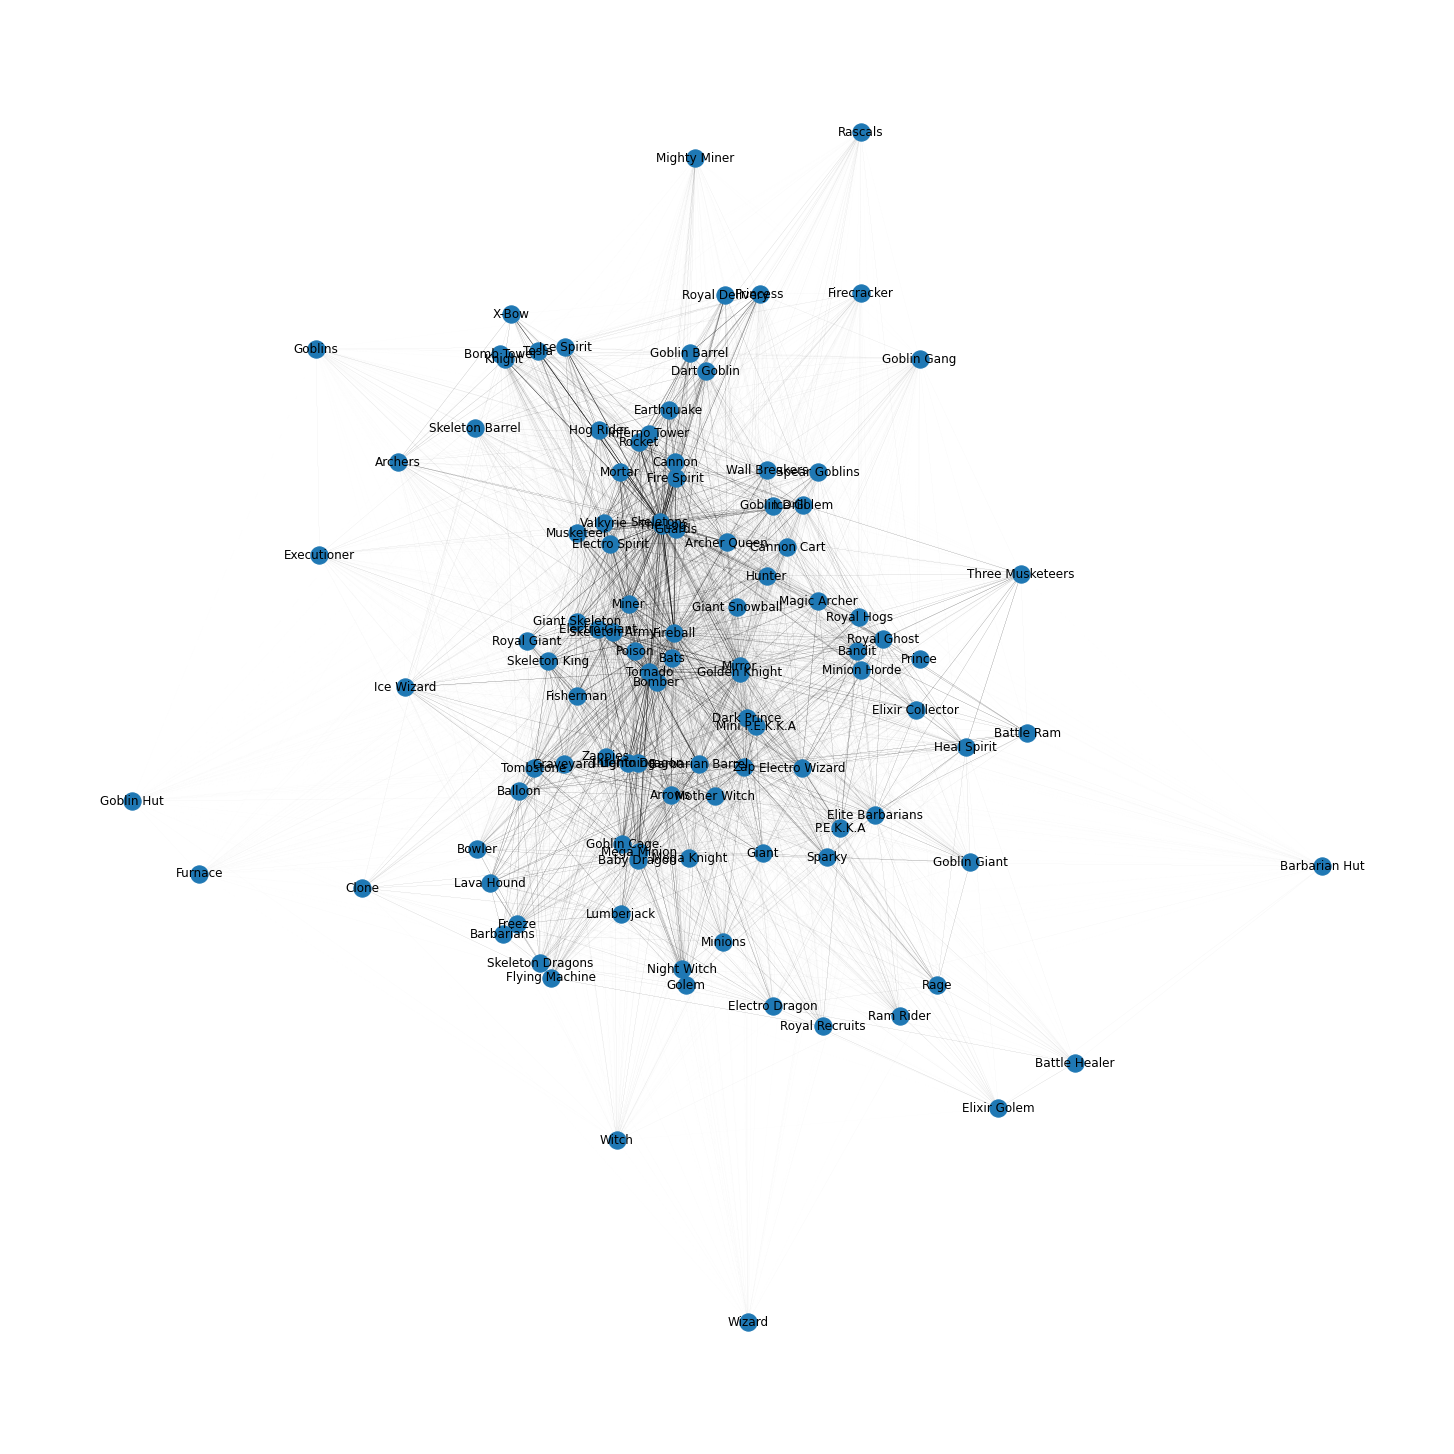

In [7]:
pl.figure(figsize=(20,20))
# nx.draw_spring(G, width=(wts/max(wts)), with_labels=True)
nx.draw_spring(G, width=(wts/max(wts)), with_labels=True)

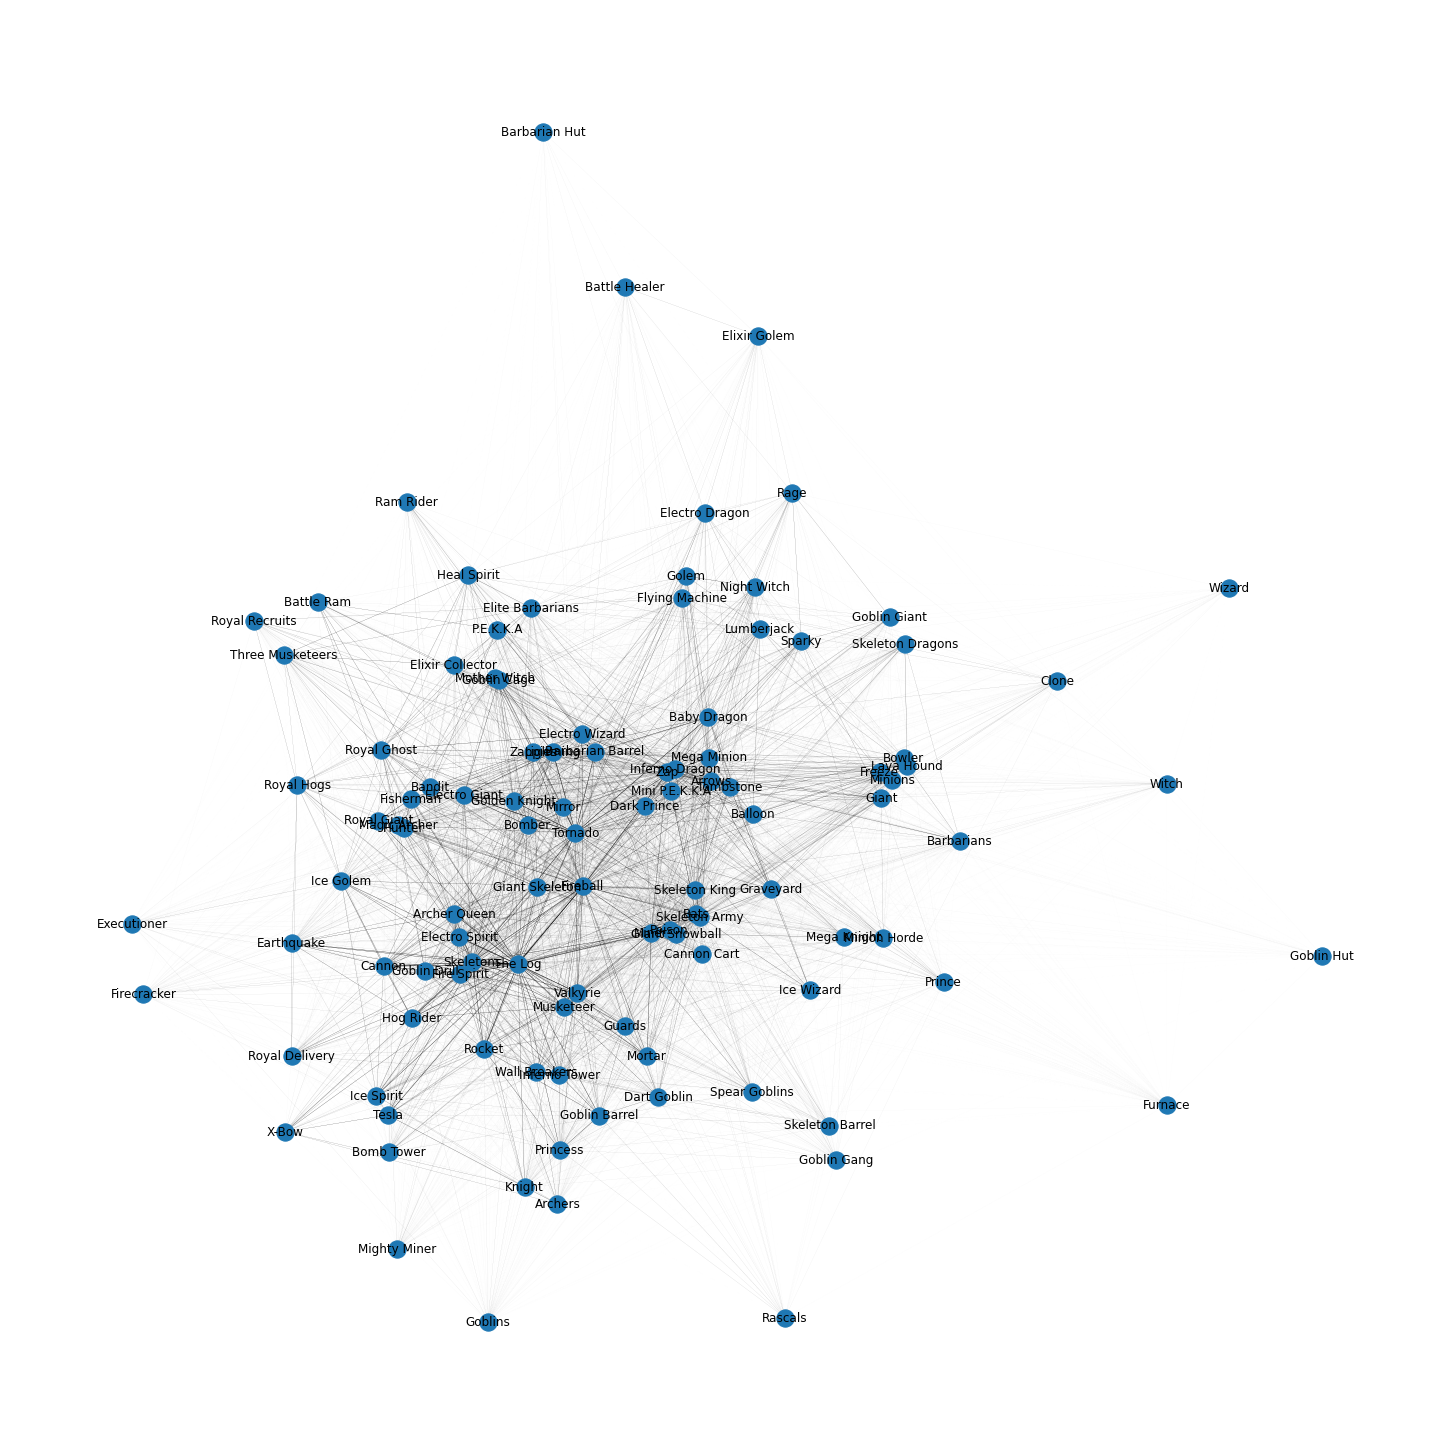

In [8]:
pl.figure(figsize=(20,20))
# nx.draw_kamada_kawai_layout(G, width=wts/max(wts), with_labels=True)
pos = nx.spring_layout(G, iterations=10000)
nx.draw(G, width=(wts/max(wts)), pos=pos, with_labels=True)

# Normalizing Data

## Method 1: Changing each connection from number of times used together to number of times seen (bi directional)

In [12]:
# CArd weights calculation

cardlist = pd.unique(el.source)
percent_el = pd.DataFrame({'source':[], 'target': [], 'weight':[]})
i = 0
for card in cardlist:
    card_total_uses = sum(el[el.source == card].weight) # how many times card was used total
    for other_card in cardlist:
        if card != other_card:
            i += 1
            edge = el[el.source == card]
            edge = edge[edge.target == other_card]
            weight = edge.weight

            other_percent_uses = weight / card_total_uses 
            percent_el = percent_el.append(pd.DataFrame({'source': card, 'target': other_card, 'weight': other_percent_uses}))

            print('percent finished:', i / len(el), end='\r') # idk why this is wrong but el and percent el come out the same length


KeyboardInterrupt: 

<BarContainer object of 0 artists>

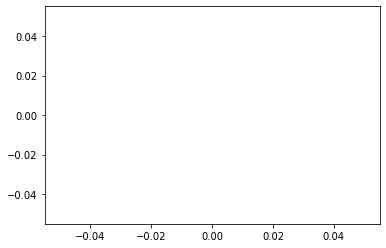

In [13]:
aq = percent_el[percent_el.source=='Miner']
aq = aq.sort_values('weight')['weight']
plt.bar([i for i in range(len(aq))], aq) 

<BarContainer object of 107 artists>

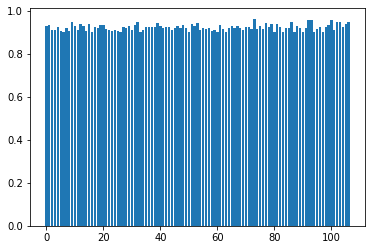

In [14]:
plt.bar([i for i in range(len(list(nx.clustering(G).values())))], list(nx.clustering(G).values()))

In [15]:
percent_el

source        target    weight
0     Archer Queen       Archers  0.000070
1     Archer Queen        Arrows  0.011621
2     Archer Queen   Baby Dragon  0.002575
3     Archer Queen       Balloon  0.002157
4     Archer Queen        Bandit  0.012386
...            ...           ...       ...
1948    Earthquake  Magic Archer  0.002698
1949    Earthquake   Mega Knight  0.001056
1950    Earthquake   Mega Minion  0.002346
1951    Earthquake  Mighty Miner  0.000586
1952    Earthquake         Miner  0.002228

[1953 rows x 3 columns]

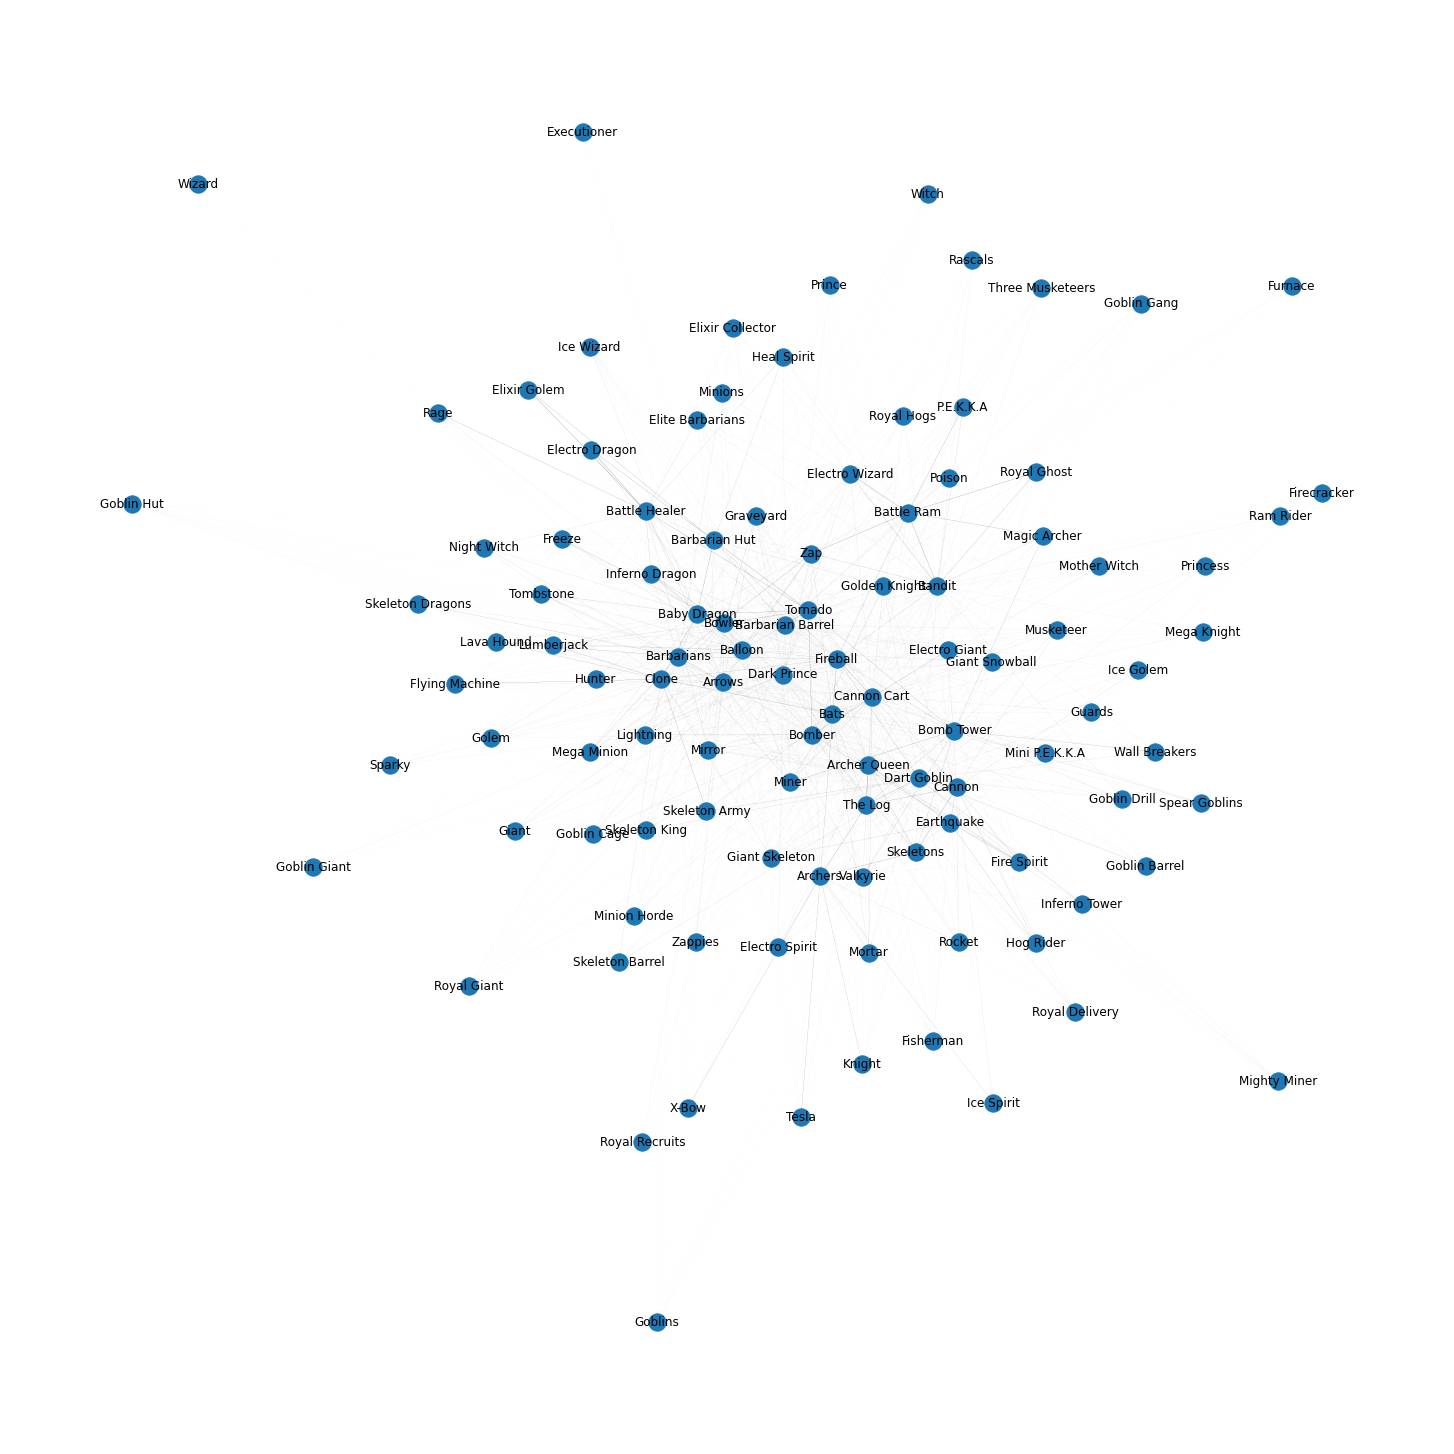

In [17]:
G2 = nx.from_pandas_edgelist(percent_el, edge_attr='weight')
wts = np.array([i['weight'] for i in dict(G2.edges).values()])

pl.figure(figsize=(20,20))
pos = nx.spring_layout(G2, iterations=100)
nx.draw(G2, width=(wts), pos=pos, with_labels=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


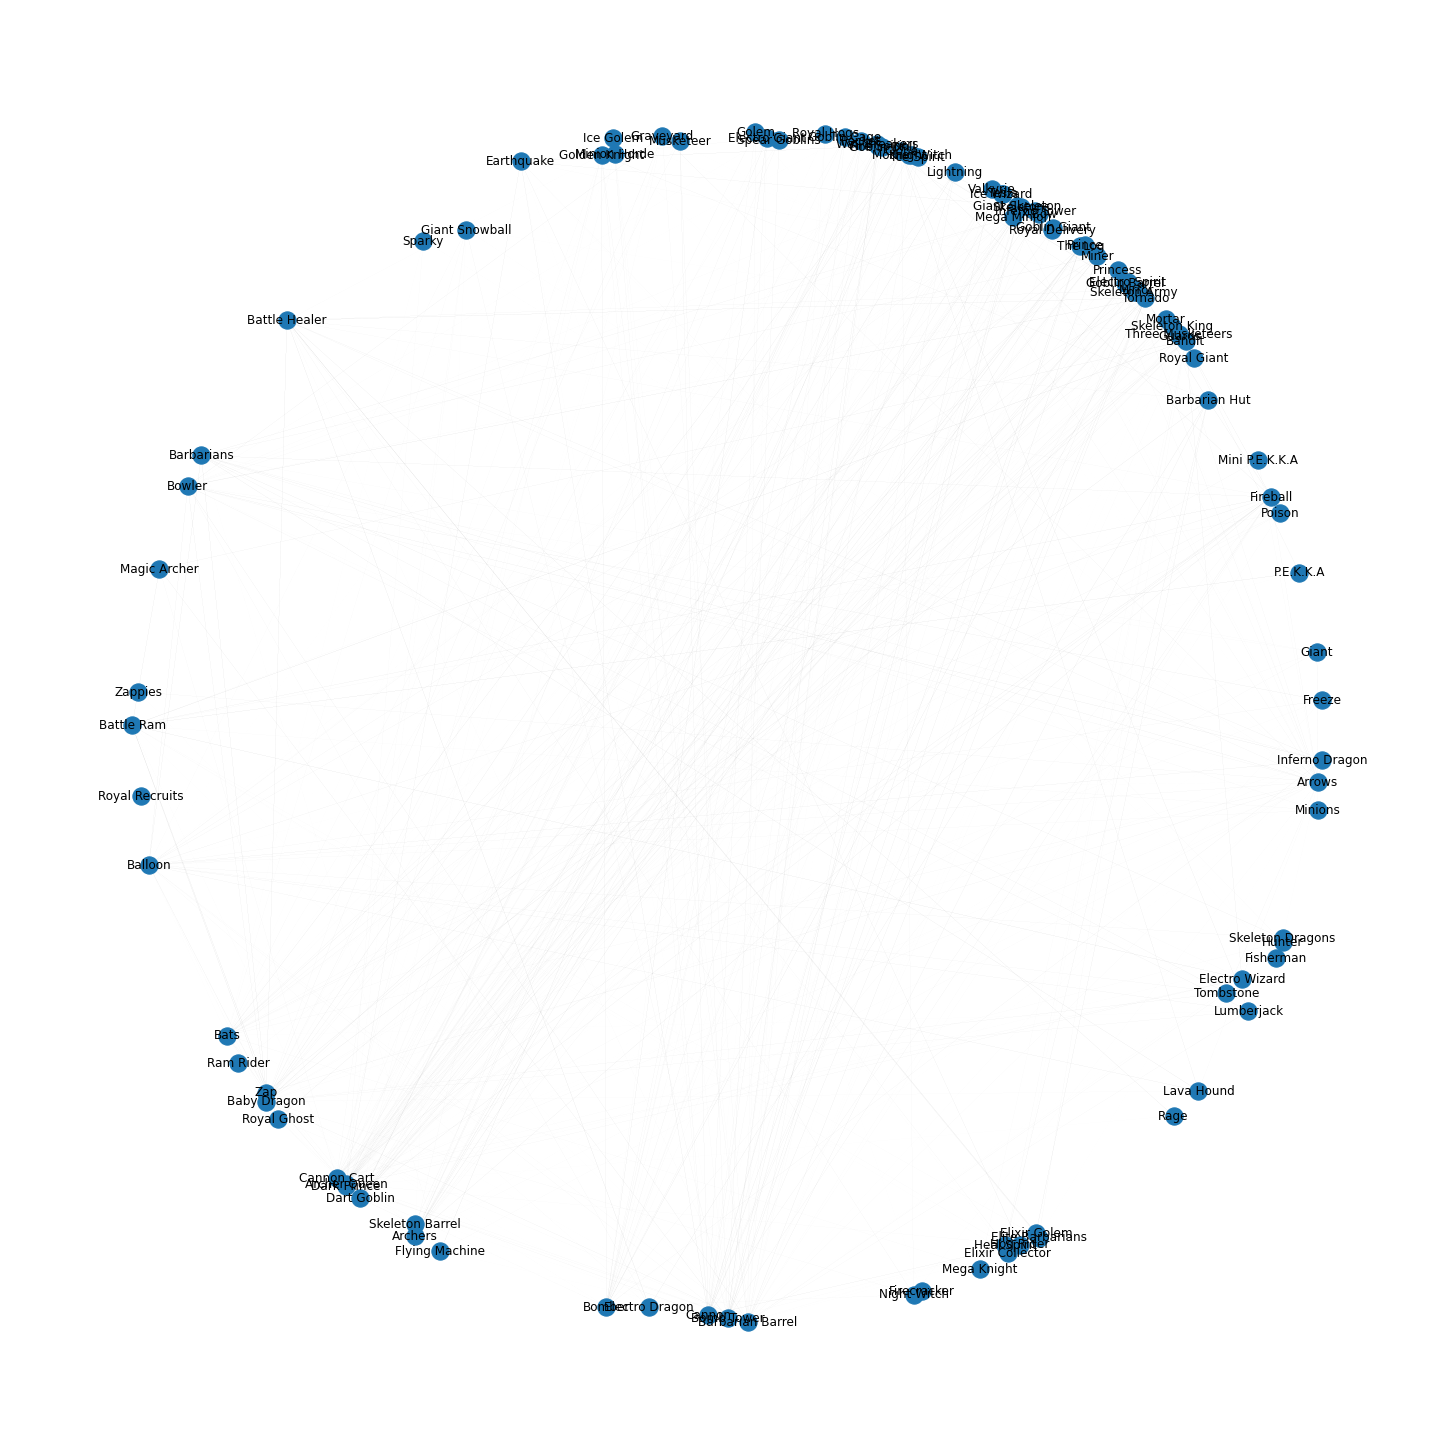

In [18]:
# removing connections with weights lower than 25th percentile
lower_bound = percent_el.quantile(0.75).weight
pruned_el = percent_el[percent_el.weight >= lower_bound]
pruned_el.weight = np.log(pruned_el.weight * 100) * -1

# new graph with new weights
G3 = nx.from_pandas_edgelist(pruned_el, edge_attr='weight')
wts = np.array([i['weight'] for i in dict(G3.edges).values()])

# plotting
pl.figure(figsize=(20,20))
pos = nx.spring_layout(G3, iterations=5000)
nx.draw(G3, width=(wts/80), pos=pos, with_labels=True)

## Method 2: Changing each weight to a number 1-n where n is number of cards based on how it ranks against other connections (not percent version)

In [20]:
# CArd weights calculation

cardlist = pd.unique(el.source)
rank_el = pd.DataFrame({'source':[], 'target': [], 'weight':[]})
i = 0
for card in cardlist:
    card_total_uses = sum(el[el.source == card].weight) # how many times card was used total
    for other_card in cardlist:
        if card != other_card:
            i += 1
            edgelist = el[el.source == card]
            ordered_by_weight =  edgelist.weight.sort_values().reset_index()
            edge = edgelist[edgelist.target == other_card]
            # print(edge.weight.values[0])
            # print(ordered_by_weight.weight)

            # print(card, other_card)
            # print(edge)

            if len(edge) > 0:
                matching = ordered_by_weight[ordered_by_weight.weight == edge.weight.values[0]].index.values
                if len(matching) > 0:
                    weight = matching[0]
                else:
                    weight = 0
                rank_el = rank_el.append(pd.DataFrame({'source': card, 'target': other_card, 'weight': [weight]}))
            else:
                pass

            # edge = edge[edge.target == other_card]
            # weight = edge.weight

            # other_percent_uses = weight / card_total_uses 
            # rank_el = rank_el.append(pd.DataFrame({'source': card, 'target': other_card, 'weight': [weight]}))

            print('percent finished:', i / len(el), end='\r') # idk why this is wrong but el and percent el come out the same length

In [22]:
rank_el

source         target  weight
0   Archer Queen        Archers     0.0
0   Archer Queen         Arrows    68.0
0   Archer Queen    Baby Dragon    35.0
0   Archer Queen        Balloon    32.0
0   Archer Queen         Bandit    70.0
..           ...            ...     ...
0        Zappies       Valkyrie    77.0
0        Zappies  Wall Breakers    13.0
0        Zappies          Witch    46.0
0        Zappies          X-Bow     0.0
0        Zappies            Zap    72.0

[10268 rows x 3 columns]

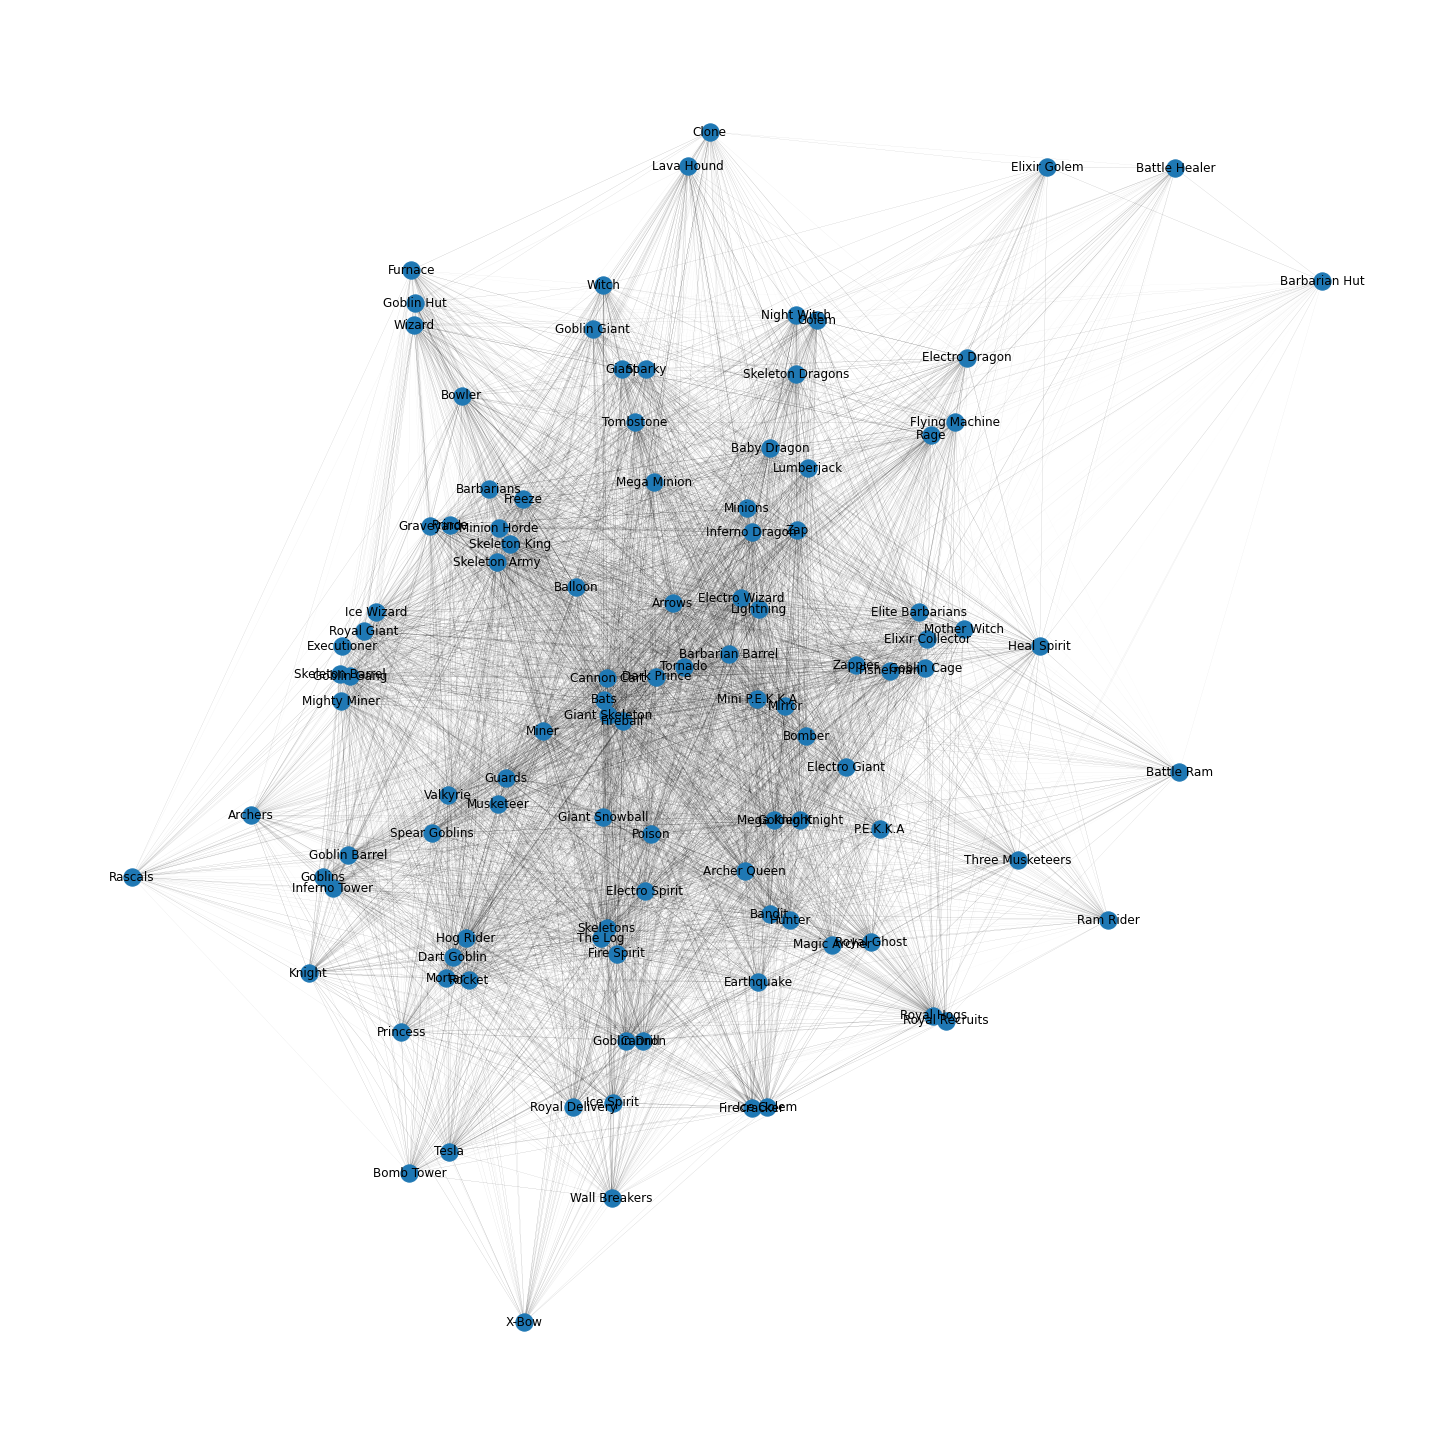

In [24]:
# new graph with new weights
G4 = nx.from_pandas_edgelist(rank_el, edge_attr='weight')
wts = np.array([i['weight'] for i in dict(G4.edges).values()])

# plotting
pl.figure(figsize=(20,20))
pos = nx.spring_layout(G4, iterations=500)
nx.draw(G4, width=(wts/900), pos=pos, with_labels=True)

In [ ]:
# Next: Fix a node in the center and move others towards it 
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html